In [1]:
import sys
sys.path.append('./')

In [2]:
import pandas as pd
import numpy as np
from constants import PROCESSED_DF_PATH
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from utils import plot_confussion_matrix, save_model, load_model, model_exists

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Leemos nuestro dataset ya procesado
df = pd.read_csv(PROCESSED_DF_PATH)

In [4]:
df.head()

,text,Bueno,Malo,Neutral
0,love amazing color black really hard see alway...,0.0,0.0,1.0
1,really like consistent bright throughout size ...,1.0,0.0,0.0
2,grand niece enjoy game,1.0,0.0,0.0
3,let say first unboxed mouse review base little...,0.0,1.0,0.0
4,kid love game he s,1.0,0.0,0.0


In [5]:
# Separamos en sets para train y test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df.drop(columns='text'), test_size=0.3, random_state=42, shuffle=True)

In [6]:
# Instanciamos el modelo de tfidf_vectorizer para realizar la codificación del texto
tfidf_vectorizer  = TfidfVectorizer(
    max_df = .95,
    min_df = 3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 2)
)

In [7]:
# Entrenamos el codificador con el set de X_train
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)

# Usamos el codificador entrenando para convertir X_test
X_test_vectoized = tfidf_vectorizer.transform(X_test)

# Debido a que tengo el dataframe ya codificado en OneHot lo transformaré a etiquetas para Machine Learning
y_train_ml, y_test_ml = np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)

# Regresión Logística con gridSearch
Ya que el algoritmo de regresión logística no es tan costoso computacionalmente podemos usar un gridsearch para encontrar los mejores parámetros

In [8]:
# Nombre del modelo de regresión logística
LR_MODEL_NAME = 'logistic_regression.pkl'
MODEL_TYPE = 'ml'

In [ ]:
# Verificamos si el modelo ya existe
if model_exists(LR_MODEL_NAME, MODEL_TYPE):
    lr = load_model(LR_MODEL_NAME, MODEL_TYPE)
# Si el modelo no existe lo instanciamos y entrenamos
else:
    # Instanciamos el modelo de regresión logística bajo una capa OVR
    base_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
    
    # Definimos los diferentes hiperparámetros a utilizar
    param_grid = {
        'estimator__C': [0.01, 0.1, 1, 5],
        'estimator__max_iter': [50, 100, 250, 500]
    }
    
    # Instanciamos GridSearchCV
    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
    
    # Entrenamos el GridSearchCV
    grid_search.fit(X_train_vectorized, y_train_ml)
    
    # Mostramos los mejores resultados e hiperparámetros
    print("Mejor score:", grid_search.best_score_)
    print("Mejores hiperparámetros:", grid_search.best_params_)    

    # Nos quedamos con el mejor modelo
    lr = grid_search.best_estimator_
    
    # Guardamos el modelo
    save_model(lr, LR_MODEL_NAME, MODEL_TYPE)

In [ ]:
# Predecimos sobre el set de test
y_pred_lr = lr.predict(X_test_vectoized)
accuracy_lr = accuracy_score(y_test_ml, y_pred_lr)

#Imprimimos el accuracy
print(f'Precisión del modelo: {accuracy_lr:.2f}')

Precisión del modelo: 0.63


In [ ]:
# Vamos a ver como se comporta el modelo con las diferentes clases
labels = list(y_test.columns)
print(classification_report(y_test_ml, y_pred_lr, target_names=labels))

              precision    recall  f1-score   support

       Bueno       0.69      0.72      0.70     17745
        Malo       0.65      0.70      0.67     18886
     Neutral       0.54      0.48      0.51     18821

    accuracy                           0.63     55452
   macro avg       0.63      0.63      0.63     55452
weighted avg       0.62      0.63      0.63     55452



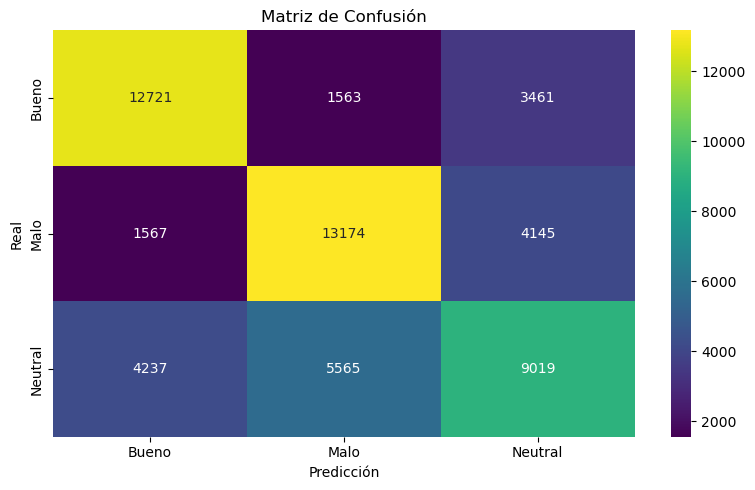

In [ ]:
# Graficamos la matriz de confusión
plot_confussion_matrix(y_test_ml, y_pred_lr, labels)